# Haystack RAG
See environment_50_Haystack_RAG.yml for the environment.

## Start DocumentStore instance

### [ElasticsearchDocumentStore](https://docs.haystack.deepset.ai/docs/elasticsearch-document-store)

In [1]:
%%bash

cd elasticsearch-8.12.2/
./bin/elasticsearch

from haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore
from haystack import Document

document_store = ElasticsearchDocumentStore(hosts = "<http://localhost:9200>")
document_store.write_documents([
    Document(content="This is first"),
    Document(content="This is second")
    ])
print(document_store.count_documents())

bash: line 2: cd: elasticsearch-8.12.2/: No such file or directory
bash: line 3: ./bin/elasticsearch: No such file or directory
bash: line 5: from: command not found
bash: line 6: from: command not found
bash: line 8: syntax error near unexpected token `('
bash: line 8: `document_store = ElasticsearchDocumentStore(hosts = "<http://localhost:9200>")'


CalledProcessError: Command 'b'\ncd elasticsearch-8.12.2/\n./bin/elasticsearch\n\nfrom haystack_integrations.document_stores.elasticsearch import ElasticsearchDocumentStore\nfrom haystack import Document\n\ndocument_store = ElasticsearchDocumentStore(hosts = "<http://localhost:9200>")\ndocument_store.write_documents([\n    Document(content="This is first"),\n    Document(content="This is second")\n    ])\nprint(document_store.count_documents())\n'' returned non-zero exit status 2.

### [OpenSearchDocumentStore](https://docs.haystack.deepset.ai/docs/opensearch-document-store)

#### NOT starting on installation, please execute the following statements to configure opensearch-dashboards service to start automatically using systemd
 sudo systemctl daemon-reload
 sudo systemctl enable opensearch-dashboards.service
#### You can start opensearch-dashboards service by executing
 sudo systemctl start opensearch-dashboards.service
#### Upcoming breaking change in packaging
 In a future release of OpenSearch Dashboards, we plan to change the permissions associated with access to installed files
 If you are configuring tools that require read access to the OpenSearch Dashboards configuration files, we recommend you add the user that runs these tools to the 'opensearch-dashboards' group
 For more information, see https://github.com/opensearch-project/opensearch-build/pull/4043

## Logging

In [1]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("50_Haystack_RAG").setLevel(logging.INFO)

## Create a Pipeline to Index Documents: raw pdfs and processed parquet files
Based on [this](https://haystack.deepset.ai/tutorials/30_file_type_preprocessing_index_pipeline) haystack tutorial.

In [2]:
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument, TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()
file_type_router = FileTypeRouter(mime_types=["text/plain", "application/pdf"])
text_file_converter = TextFileToDocument()
pdf_converter = PyPDFToDocument()
document_joiner = DocumentJoiner()

In [3]:
document_cleaner = DocumentCleaner()
document_splitter = DocumentSplitter(split_by="word", 
                                     split_length=300, 
                                     split_overlap=50)

In [4]:
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
document_writer = DocumentWriter(document_store)

In [5]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=text_file_converter, name="text_file_converter")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")

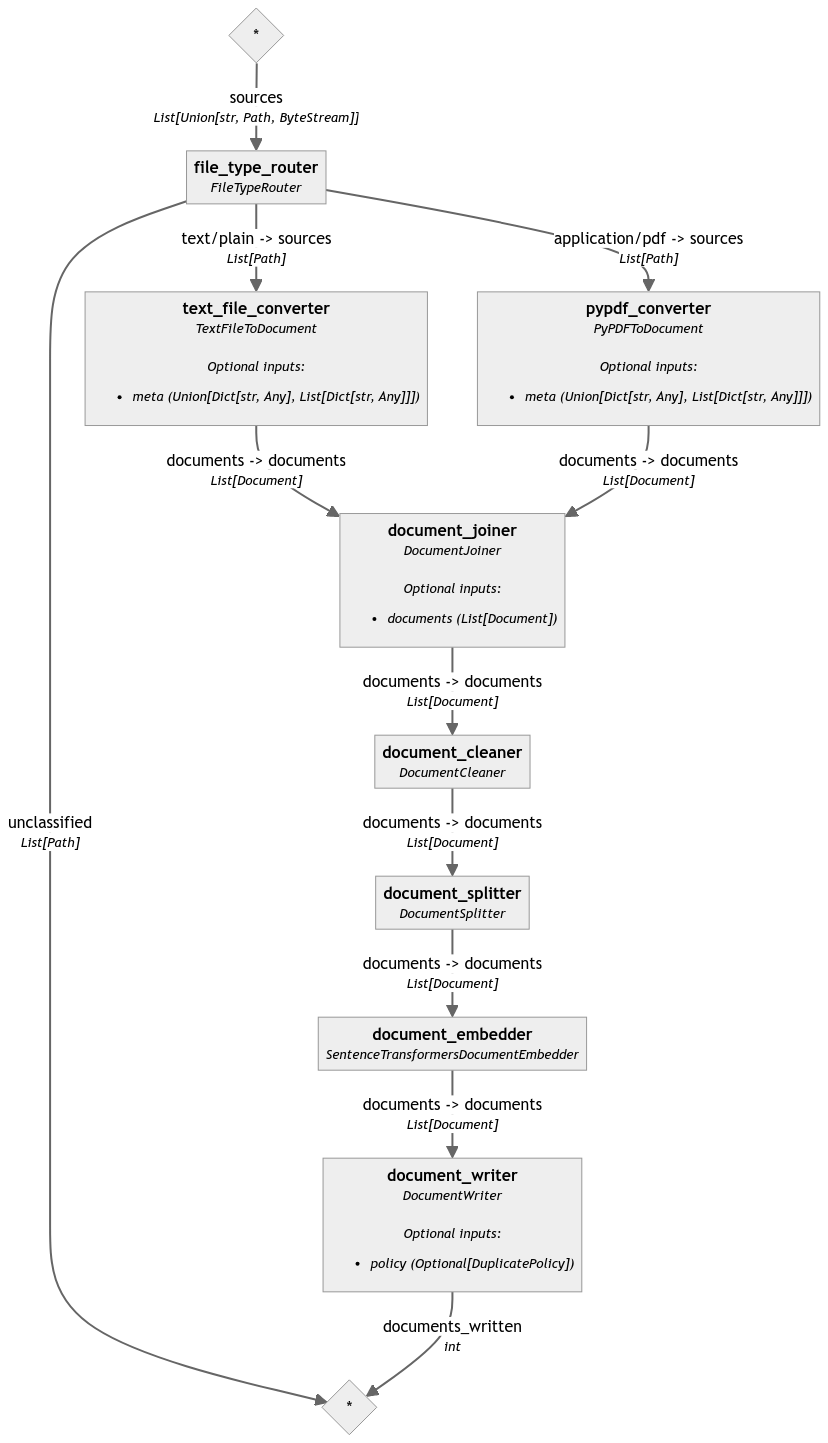

In [6]:
preprocessing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("text_file_converter", "document_joiner")
preprocessing_pipeline.connect("pypdf_converter", "document_joiner")
preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")

## Write documents

### Raw pdfs and text 

In [7]:
import os
import glob

docs = []
doc_types = ["AC", "FAR", "ORDERS"]

for doc_type in doc_types:
    docs += glob.glob(os.path.join(os.getcwd(), "data", "DRS", "raw data", doc_type, "pdf", "Current_*.*"))

docs = [doc for doc in docs if ("__-1." not in os.path.basename(doc)) and (os.stat(doc).st_size>1000)]

# docs = docs[:50]
# print(docs)

preprocessing_pipeline.run(
    {
        "file_type_router": {
            "sources": docs
        }
    }
)

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Batches:   0%|          | 0/2490 [00:00<?, ?it/s]

{'file_type_router': {'unclassified': [PosixPath('/home/victor/NLP/FAA-NLP-Project/data/DRS/raw data/AC/pdf/Current__DRSDOCID136949590320221014001007__20-152A Public Comment Log.docx__0.docx'),
   PosixPath('/home/victor/NLP/FAA-NLP-Project/data/DRS/raw data/AC/pdf/Current__DRSDOCID192416064820230418232801__AC 33.15-3-(PBF)-Public Combined Disposition Comments.docx__0.docx'),
   PosixPath('/home/victor/NLP/FAA-NLP-Project/data/DRS/raw data/AC/pdf/Current__DRSDOCID136130206020220825151401__AC_135-43_CHG_1.docx__0.docx'),
   PosixPath('/home/victor/NLP/FAA-NLP-Project/data/DRS/raw data/AC/pdf/Current__DRSDOCID100150982820230710205923__AC_33_70_4_PUBLIC_CONSOLIDATED_Dispo..xlsx__0.xlsx'),
   PosixPath('/home/victor/NLP/FAA-NLP-Project/data/DRS/raw data/AC/pdf/Current__DRSDOCID152308457920230626180932__AC 61-138A.docx__0.docx'),
   PosixPath('/home/victor/NLP/FAA-NLP-Project/data/DRS/raw data/AC/pdf/Current__DRSDOCID125827870420230203164059__AC_33.83-2B-Public-Comment-Dispo.xlsx__0.xlsx'),

### Load parquet files

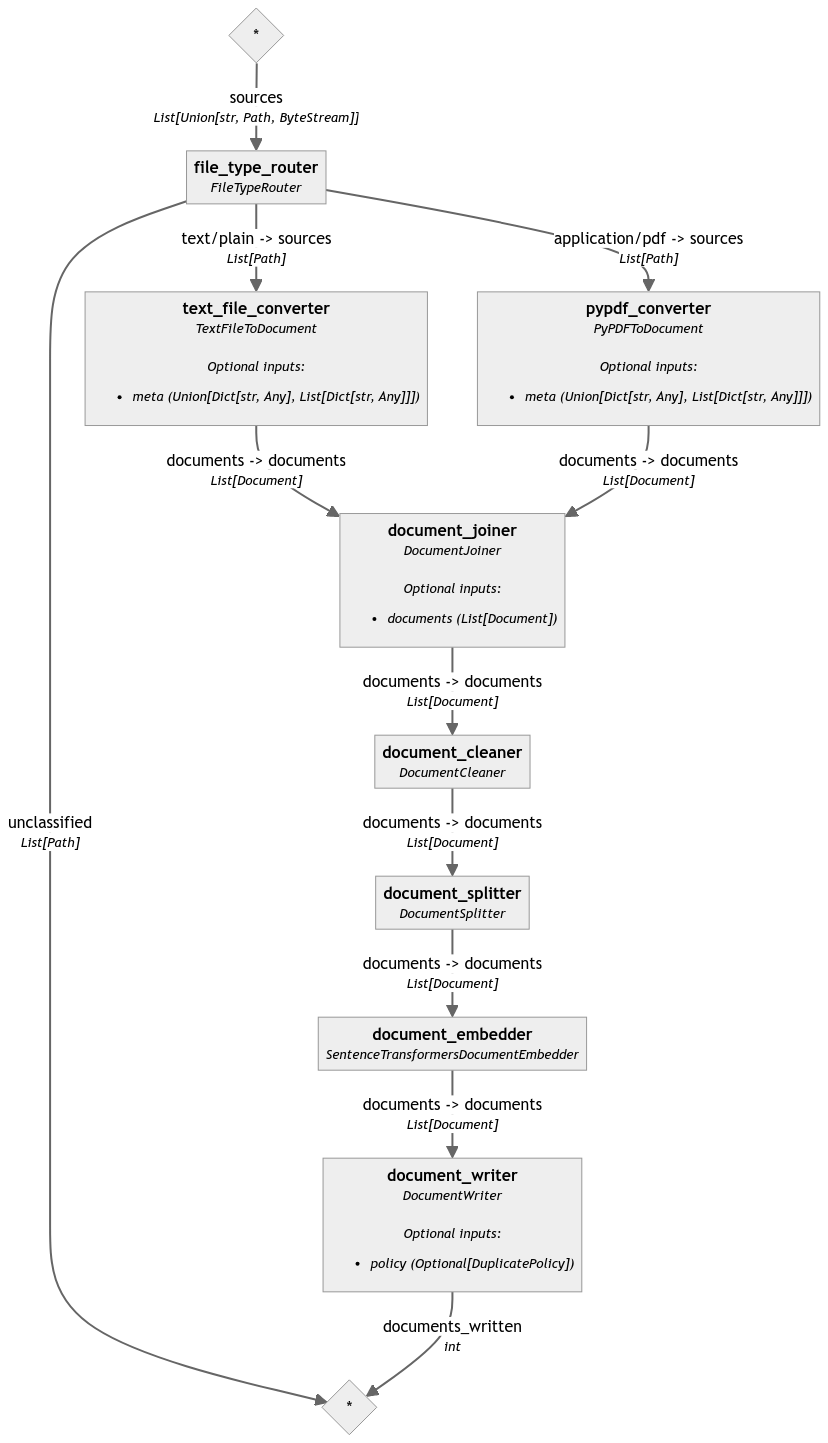

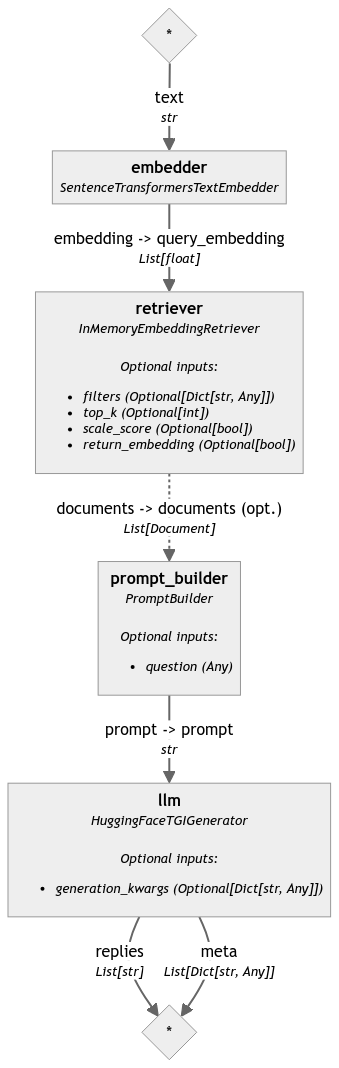

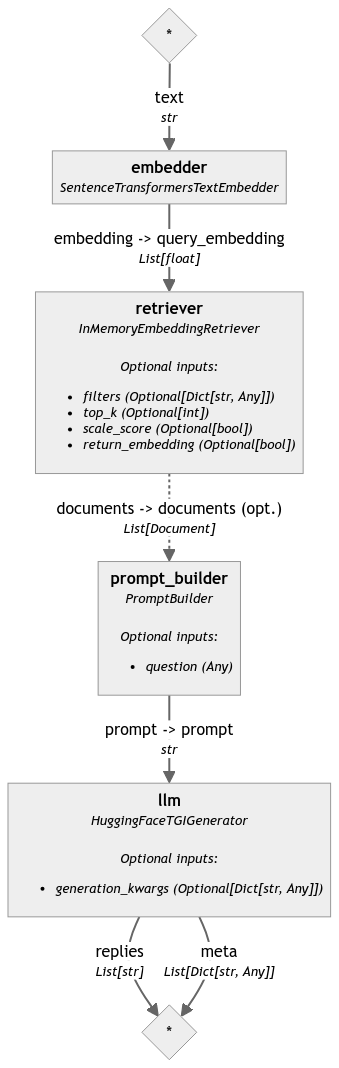

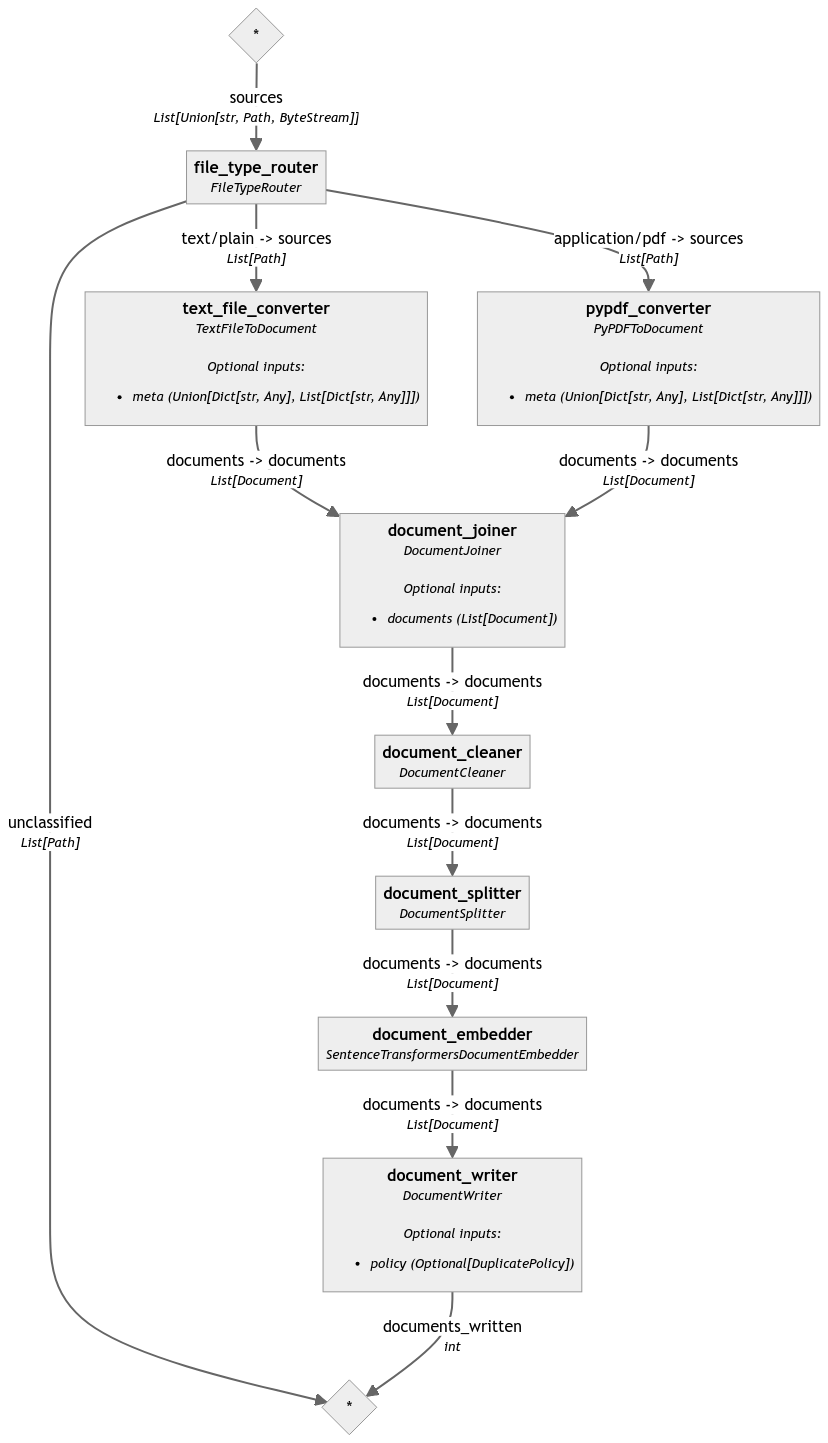

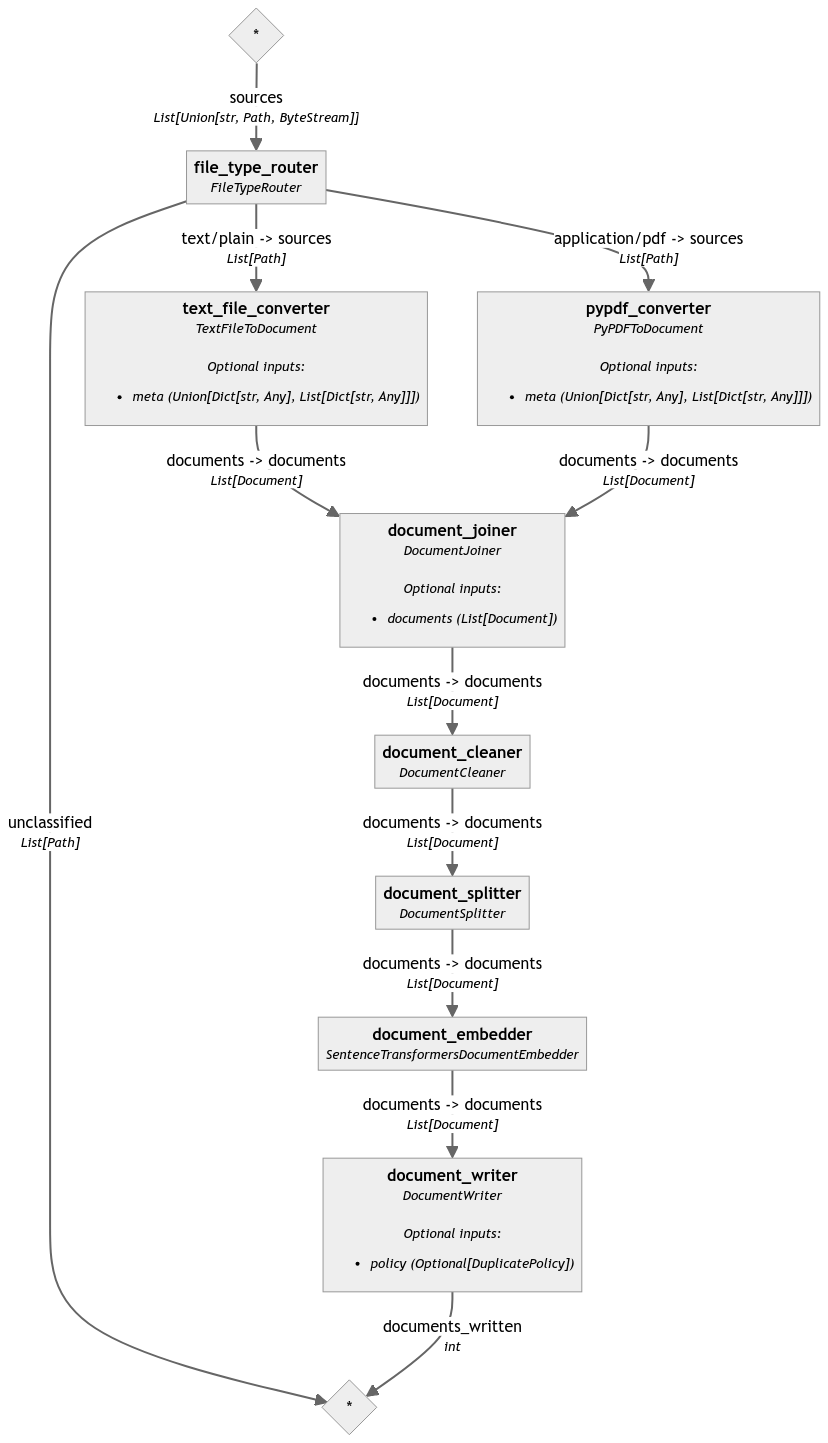

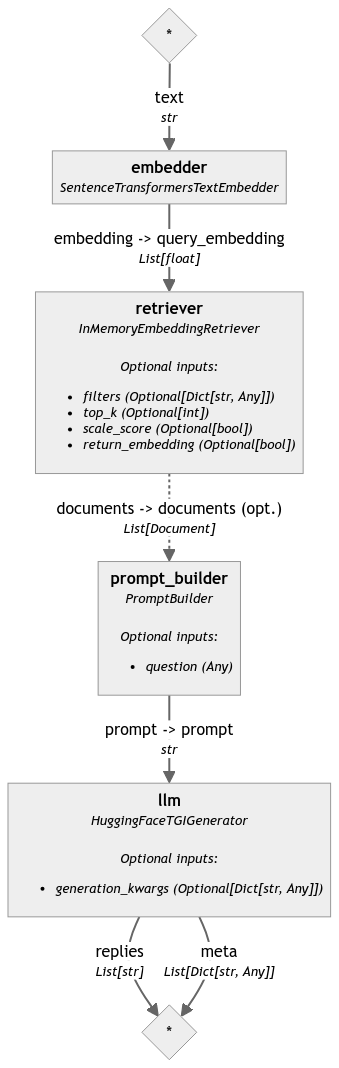

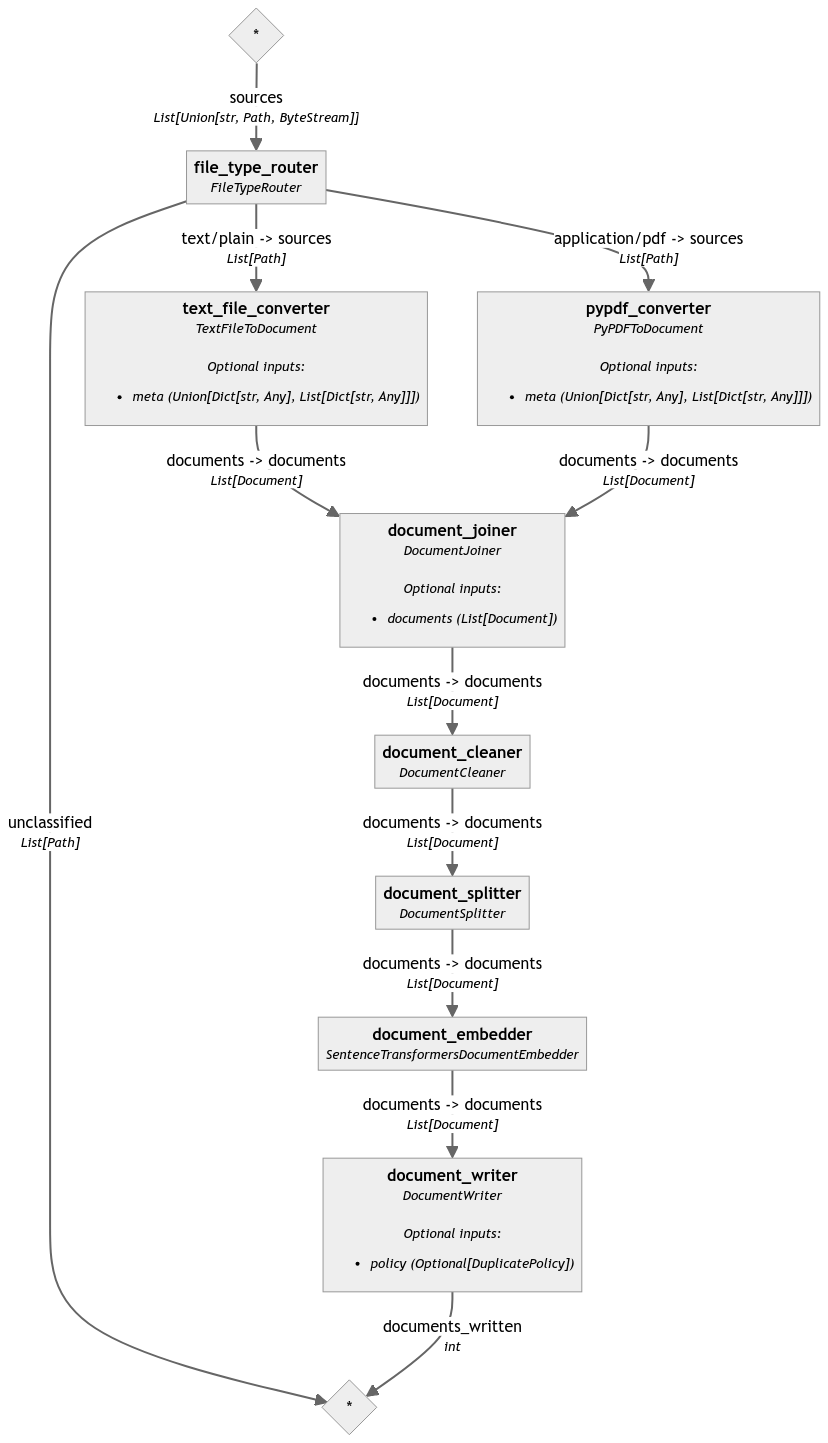

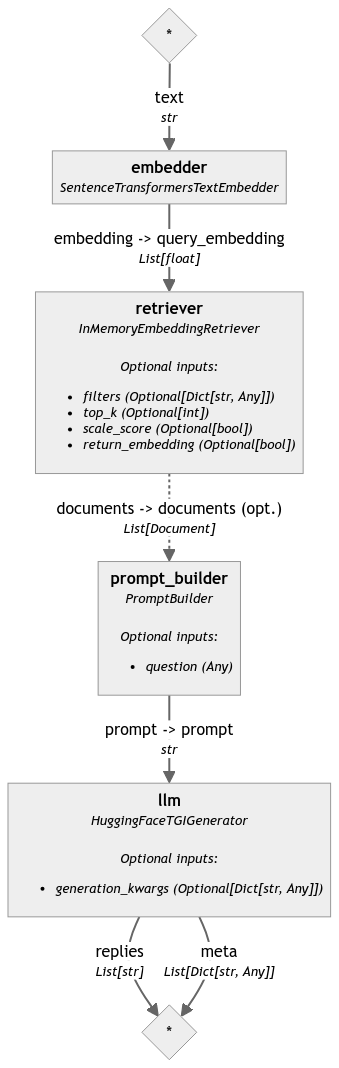

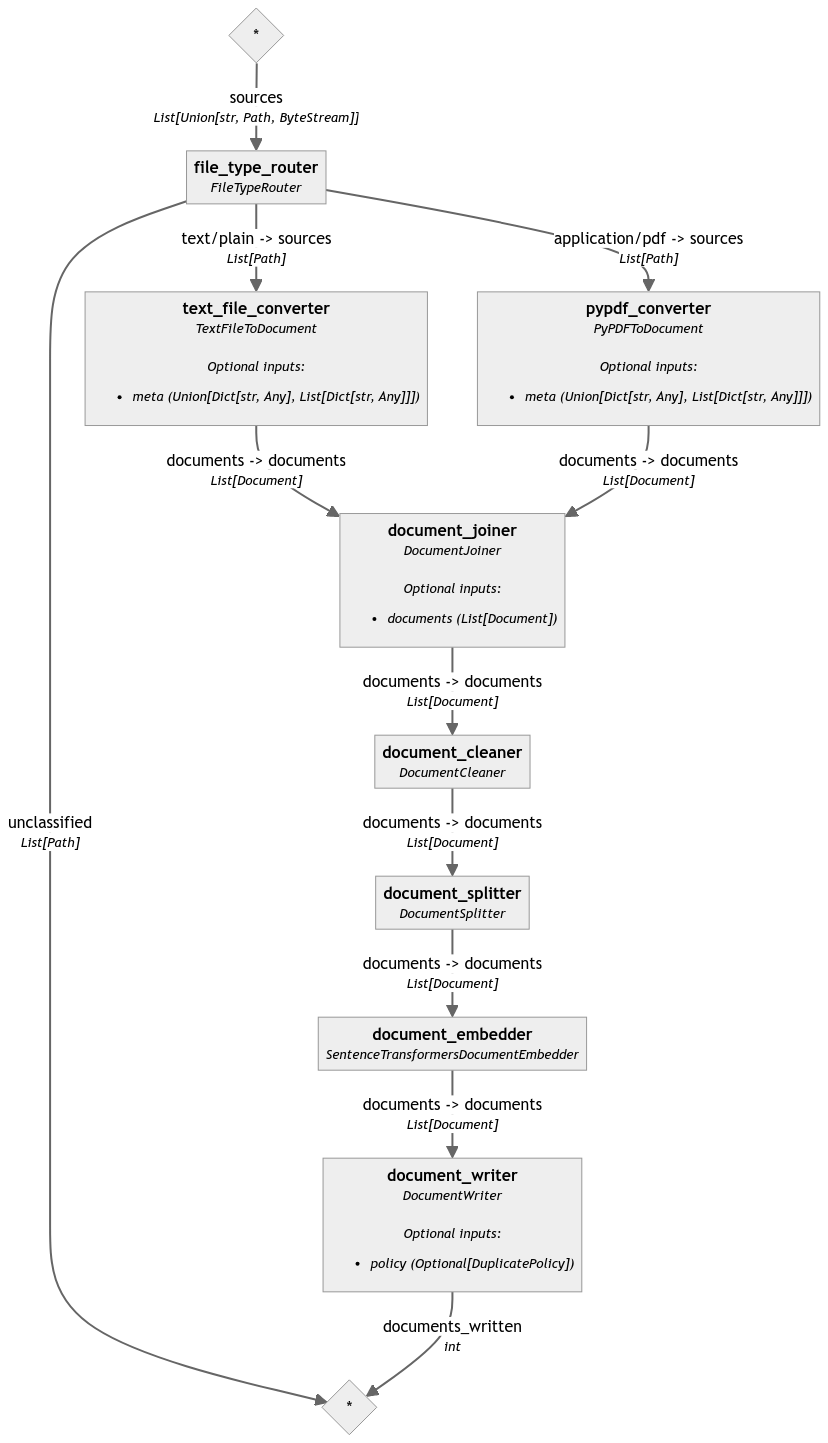

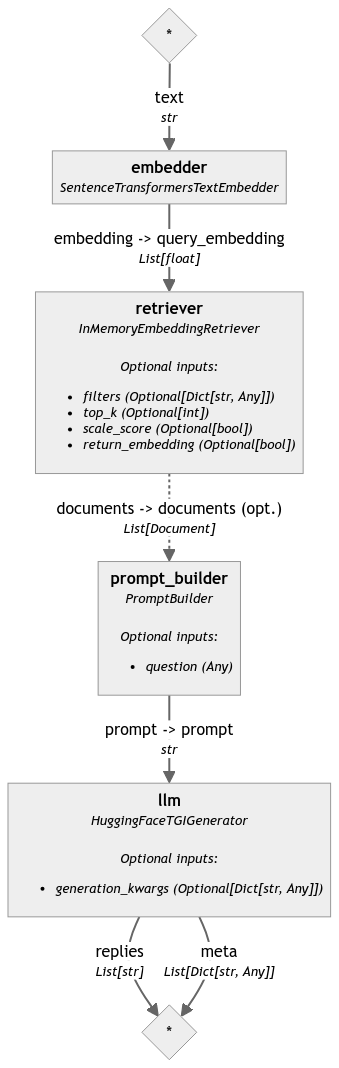

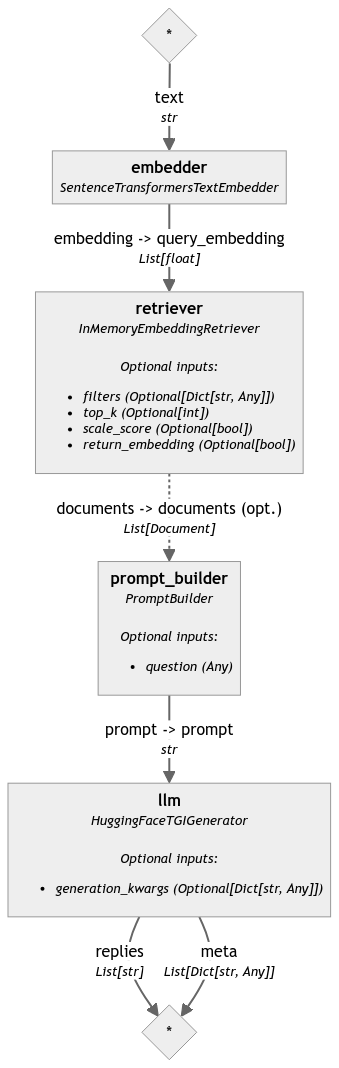

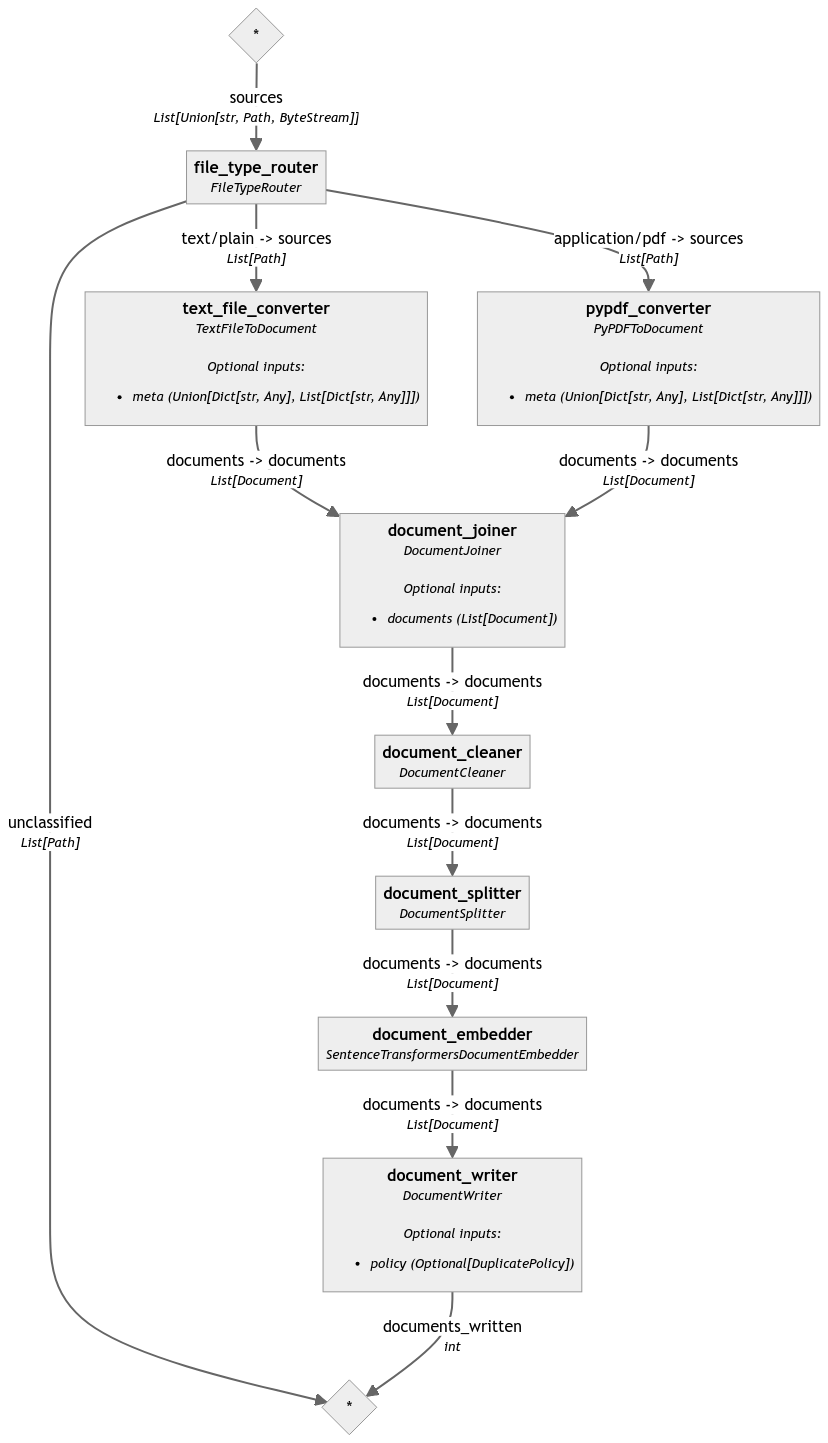

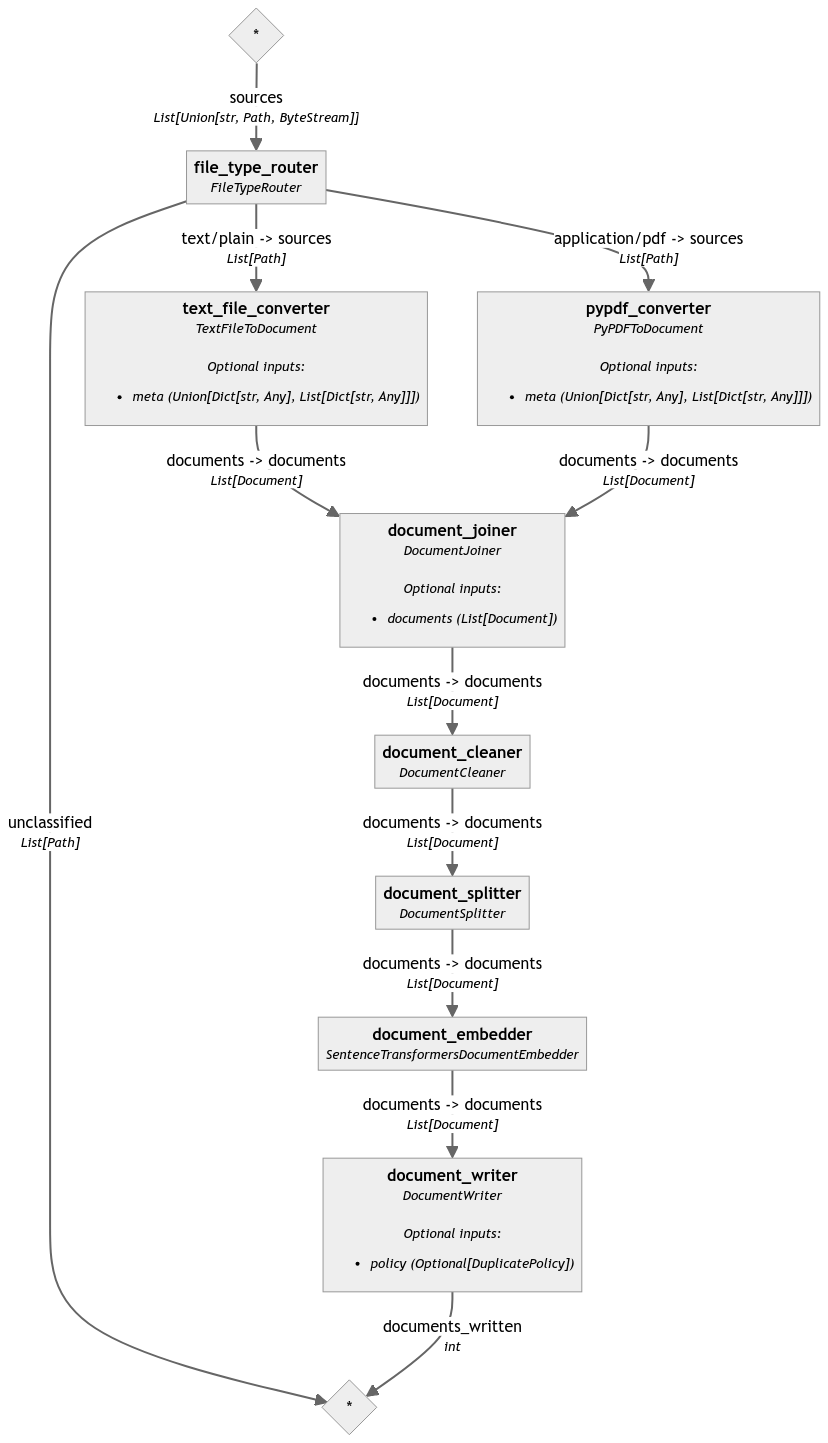

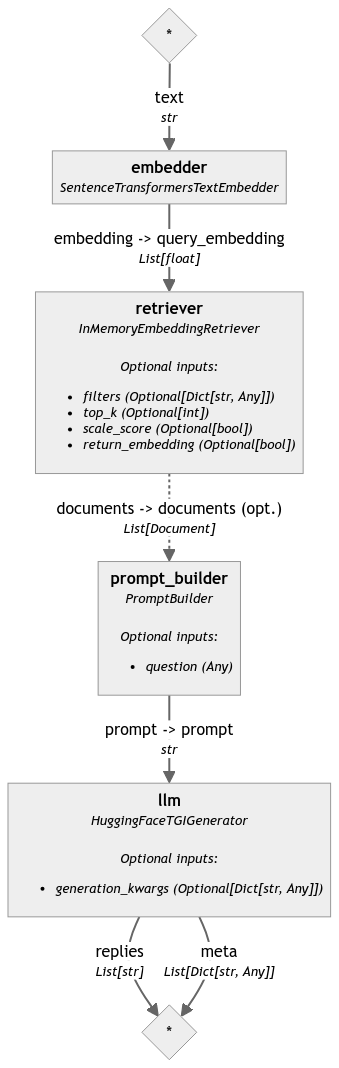

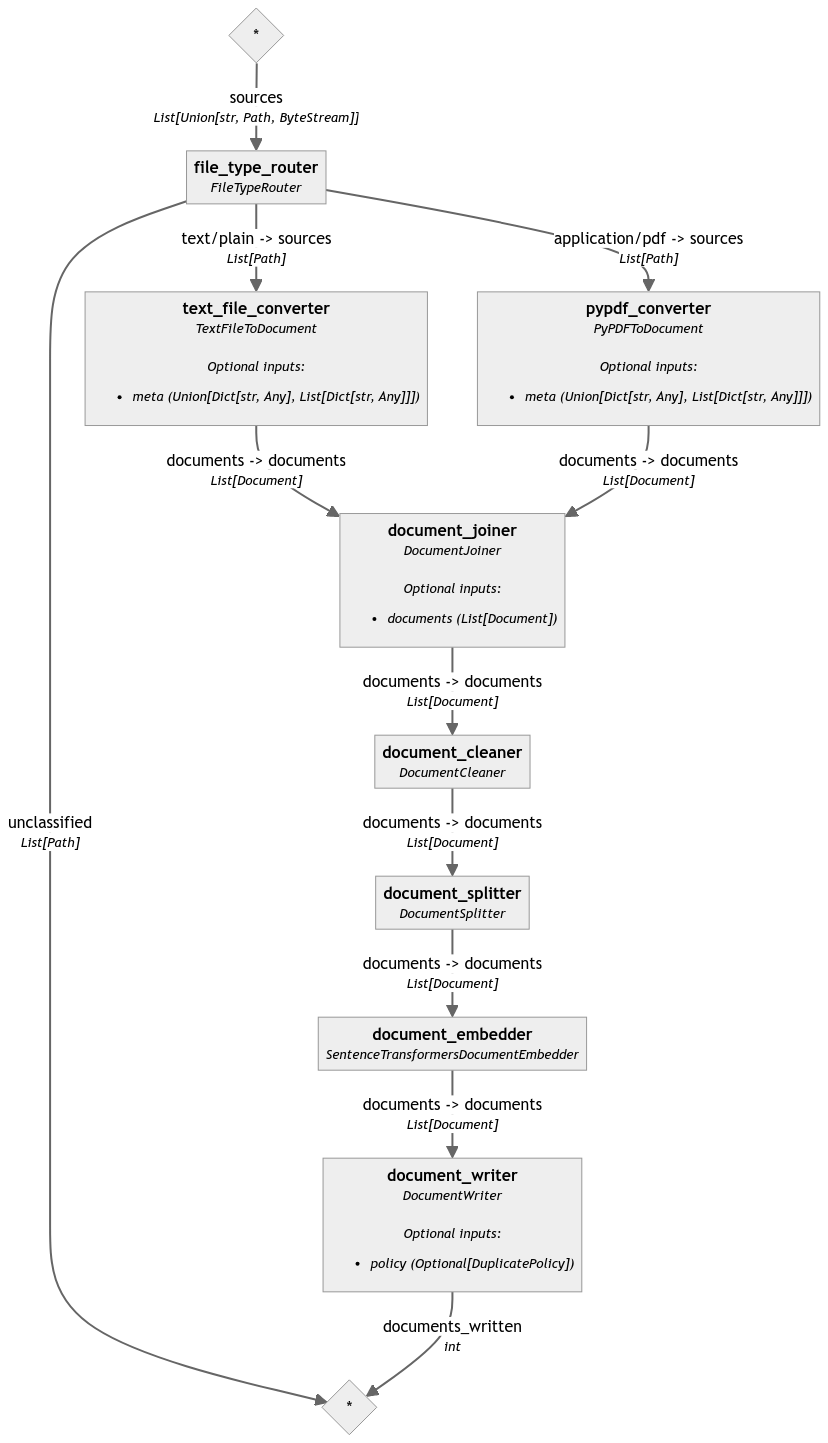

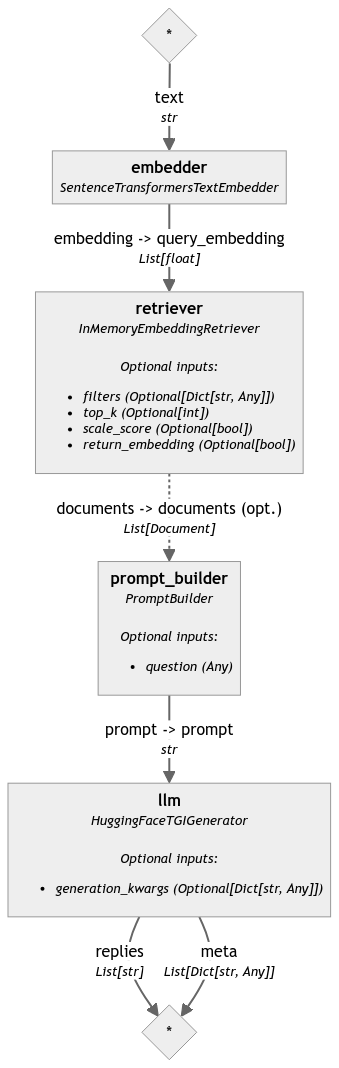

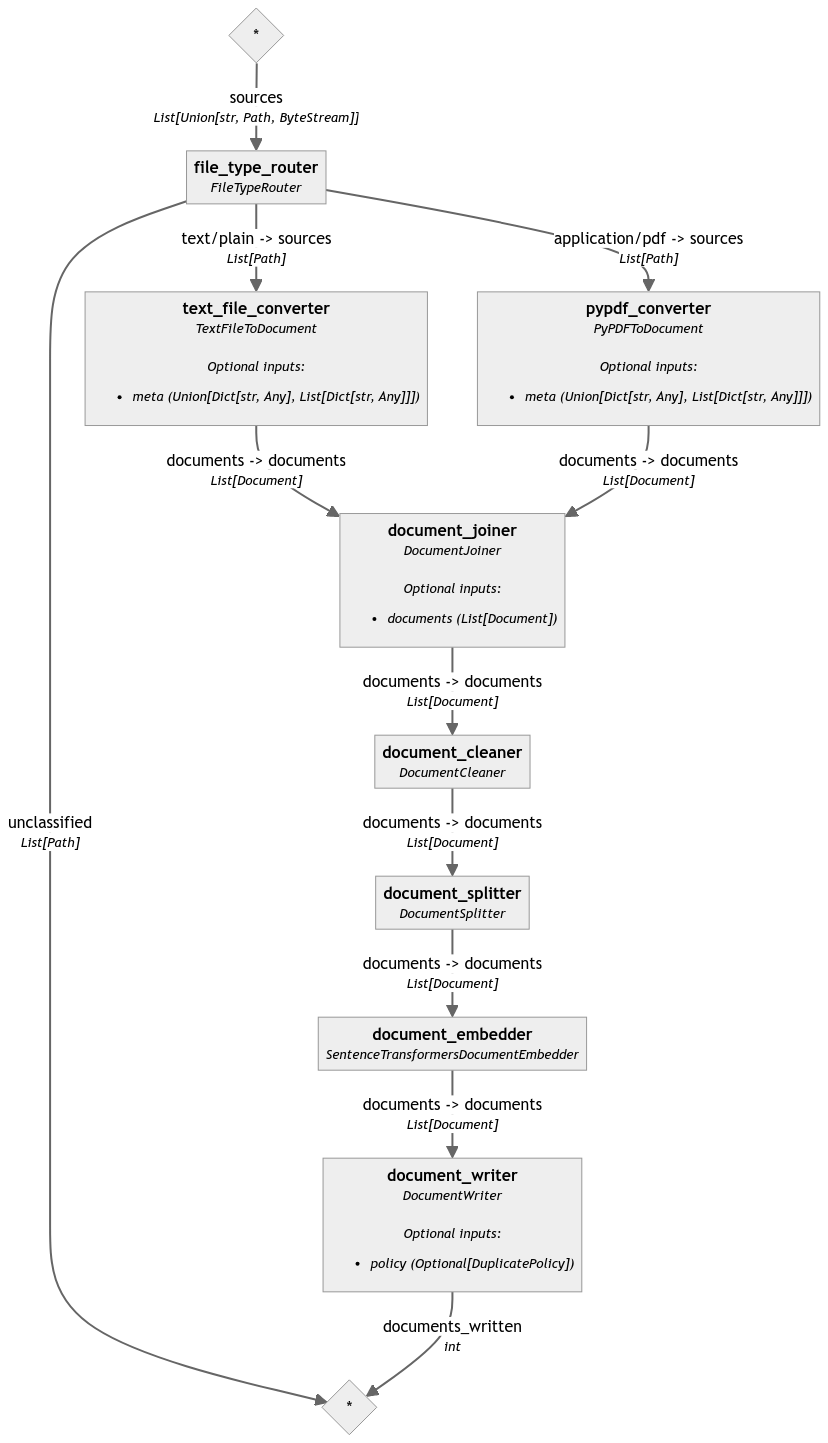

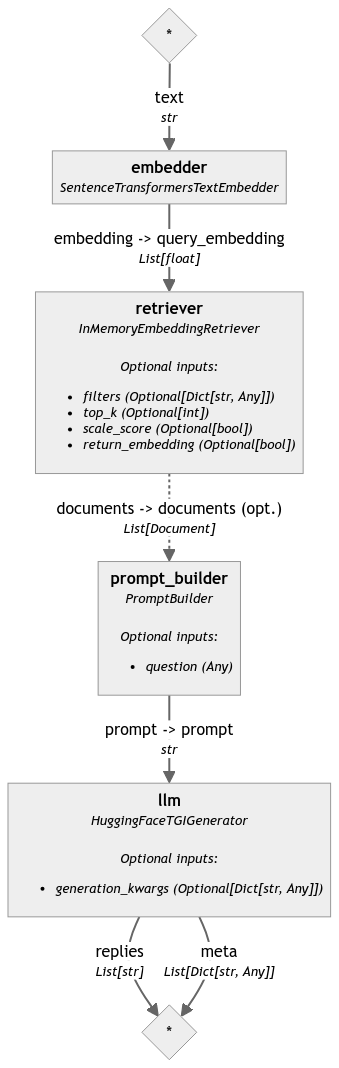

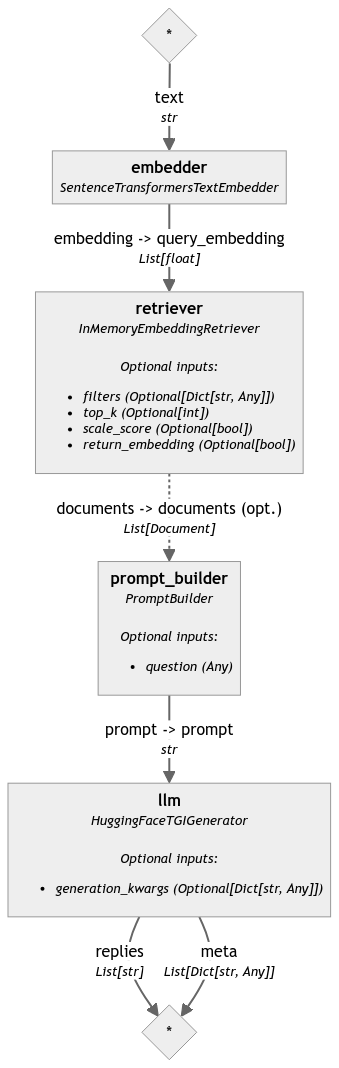

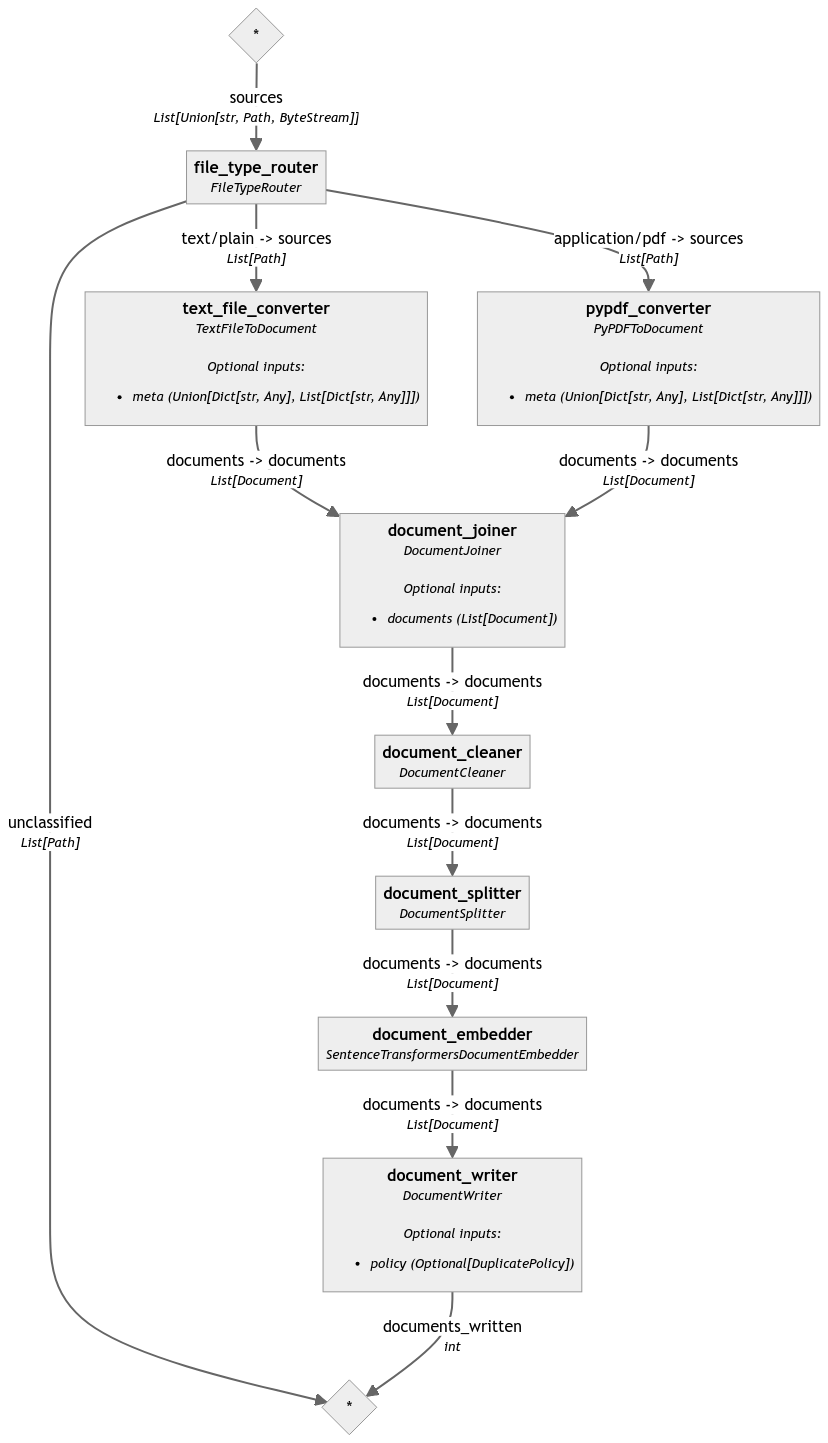

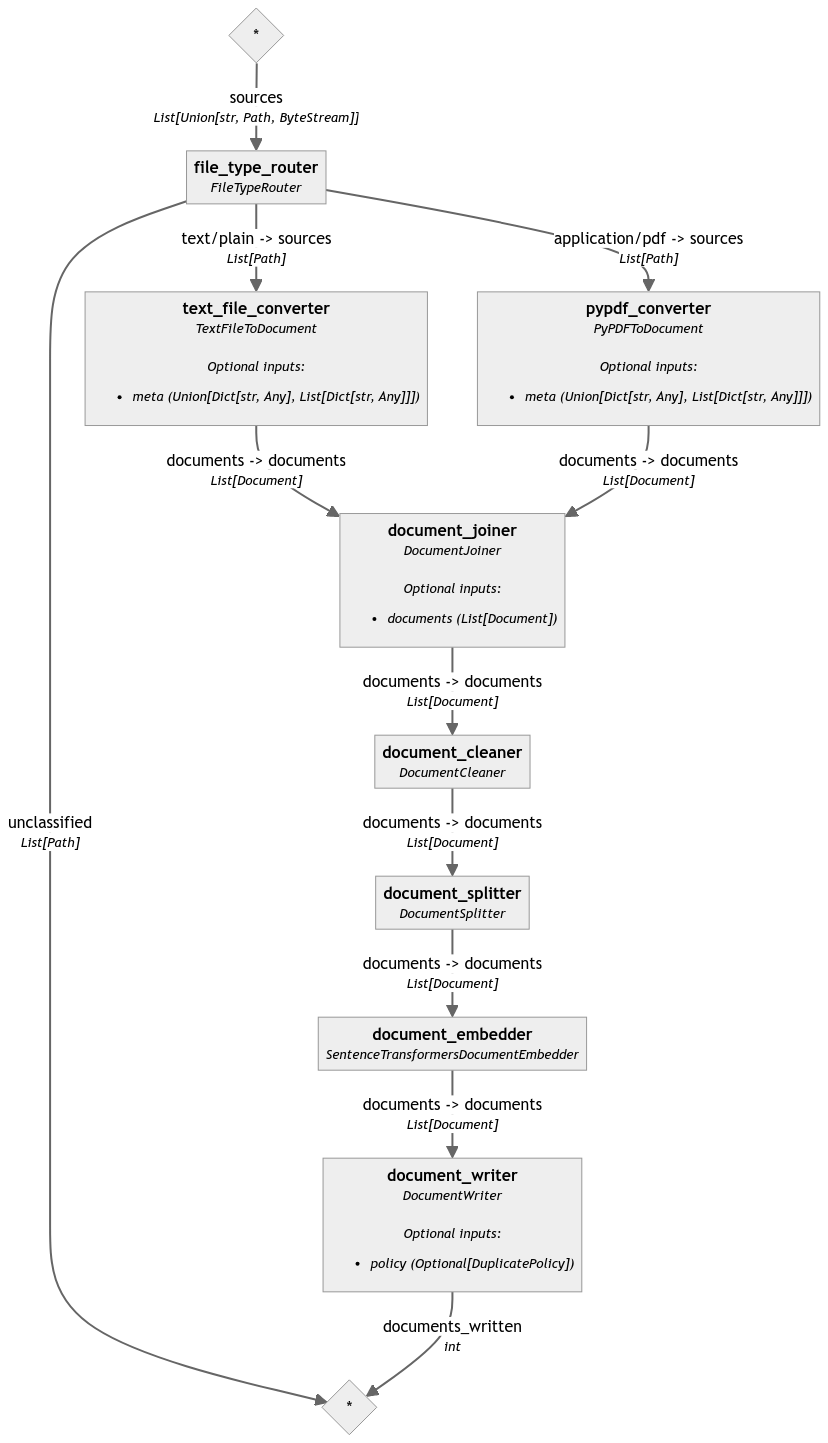

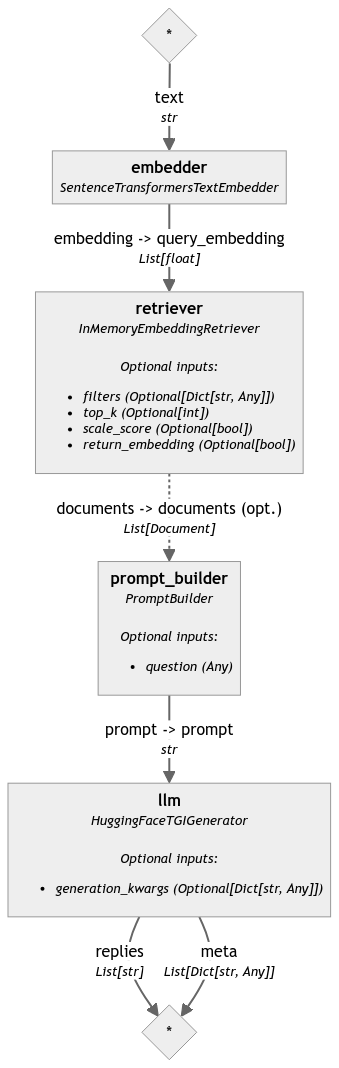

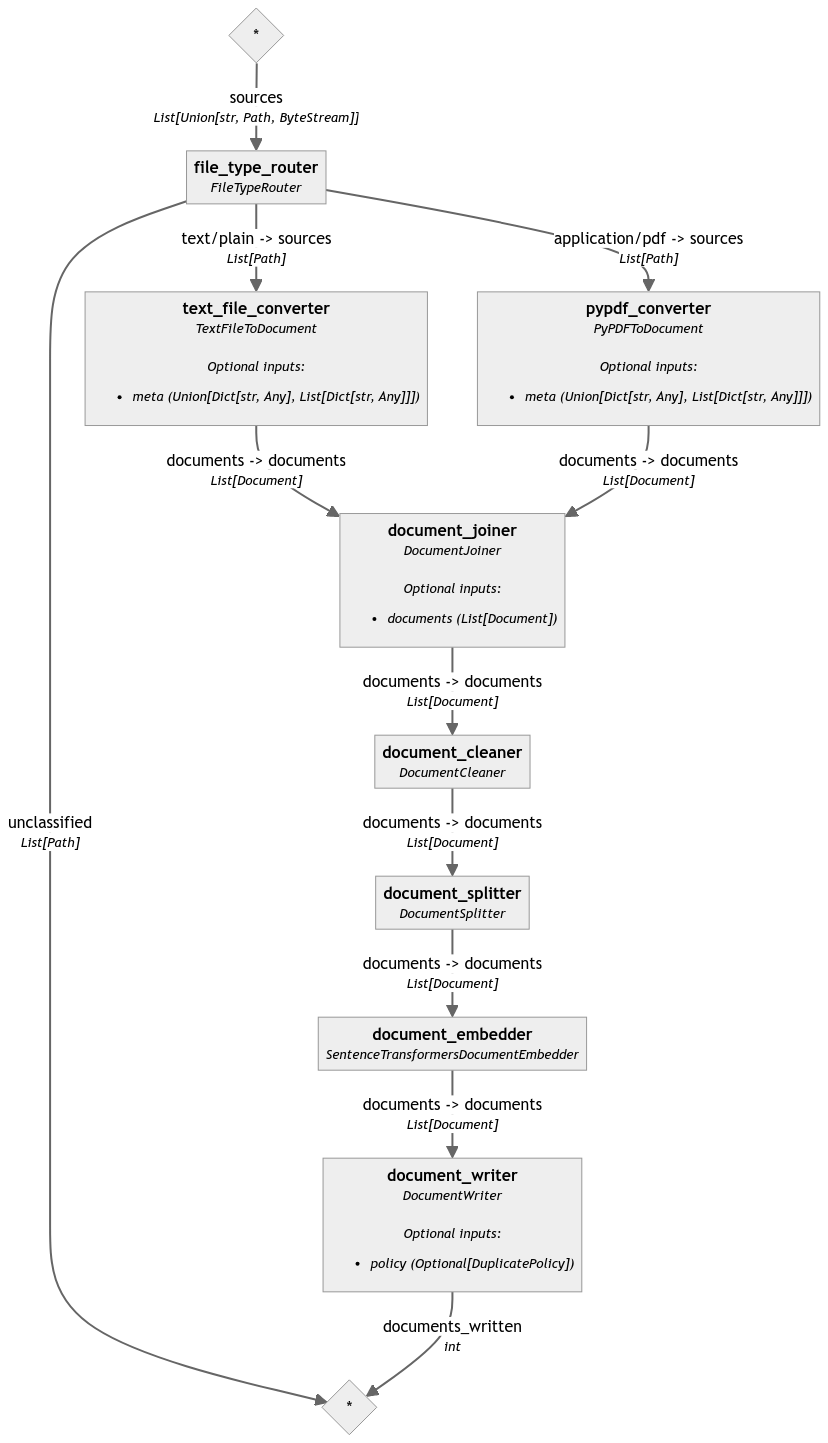

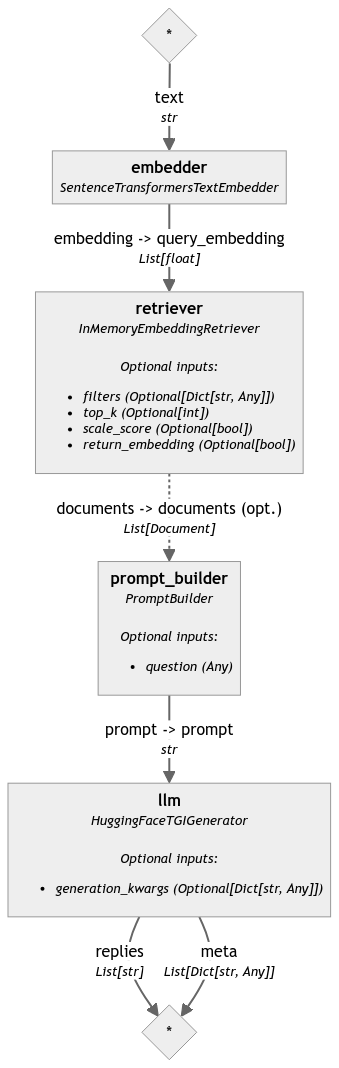

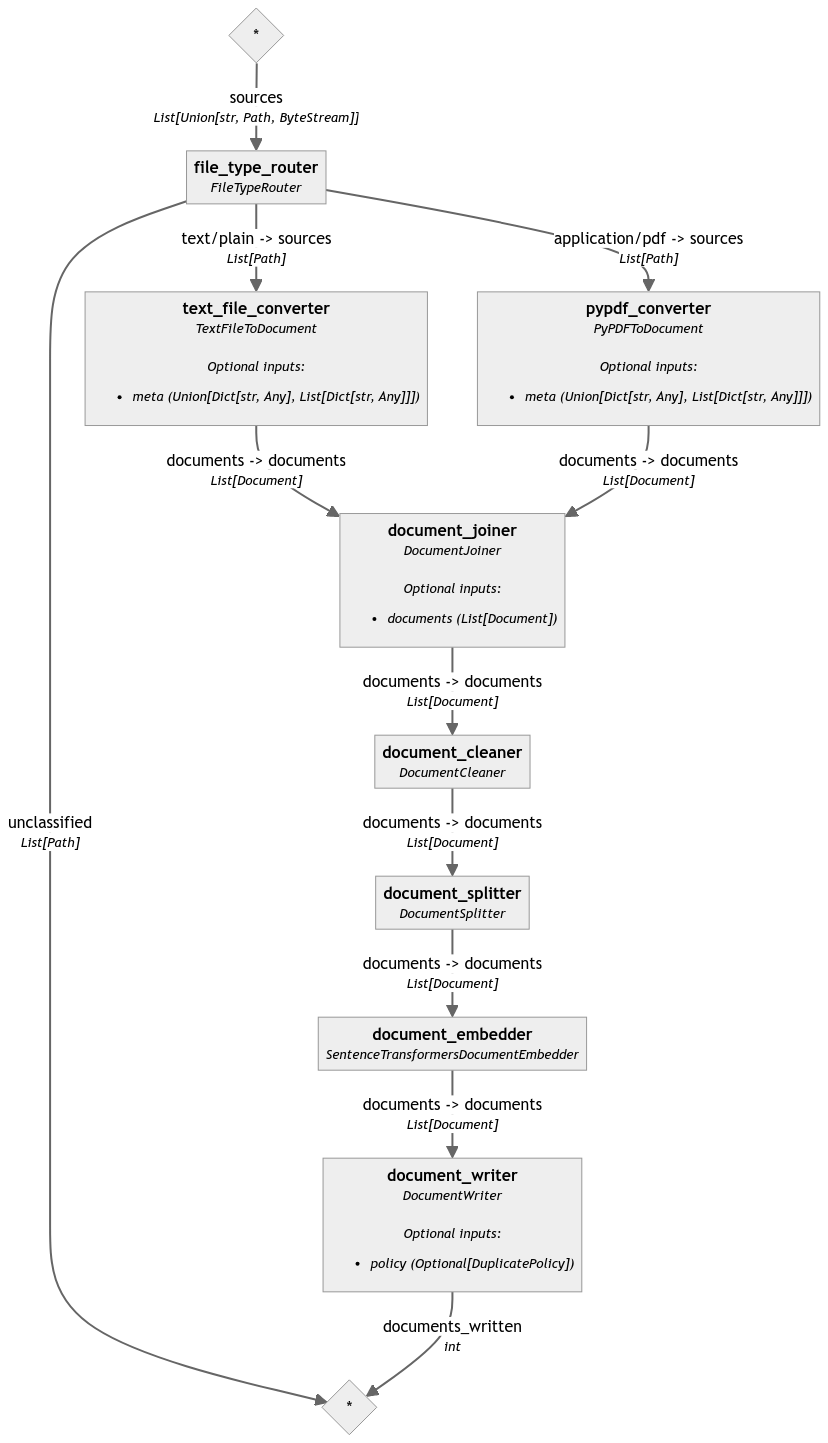

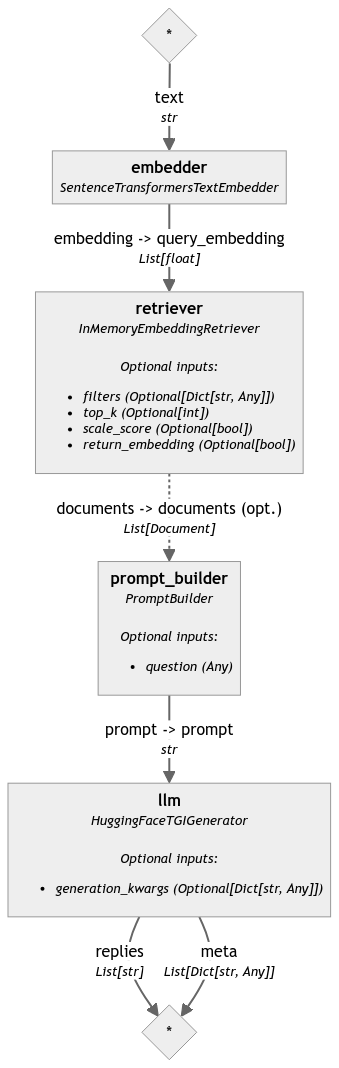

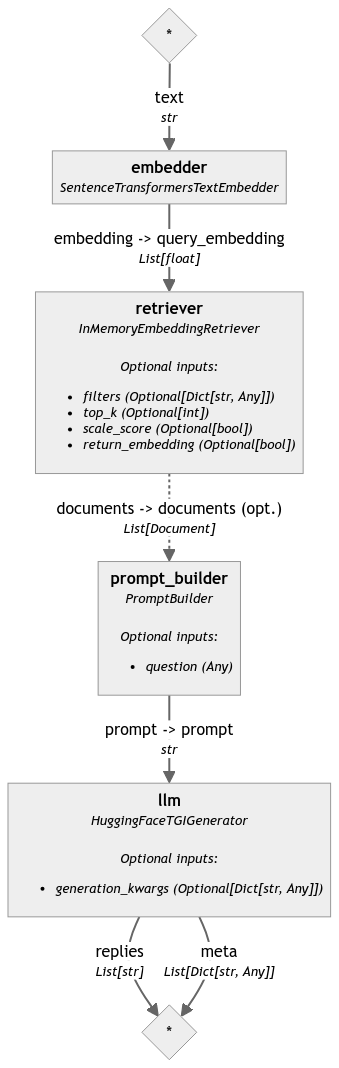

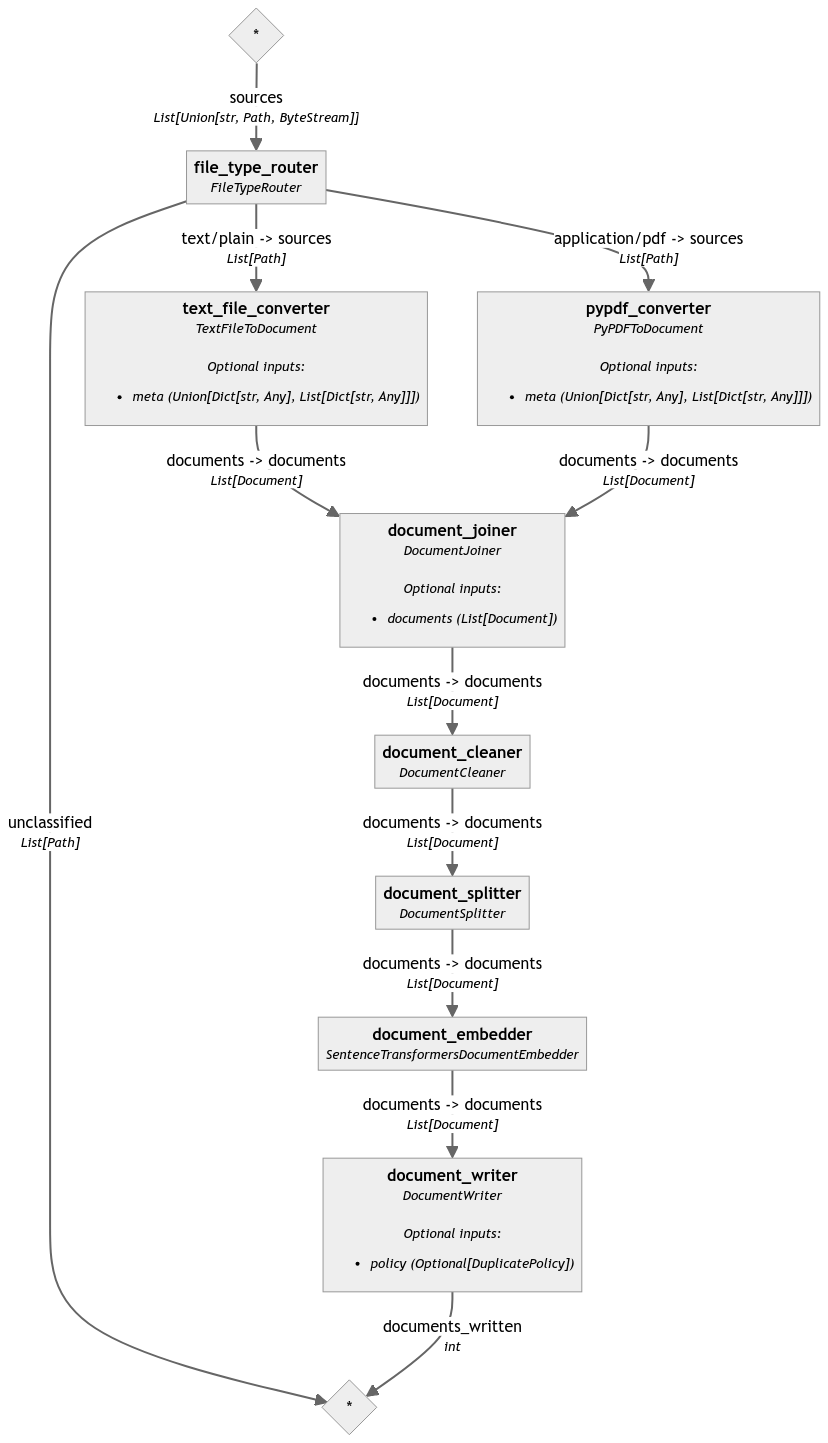

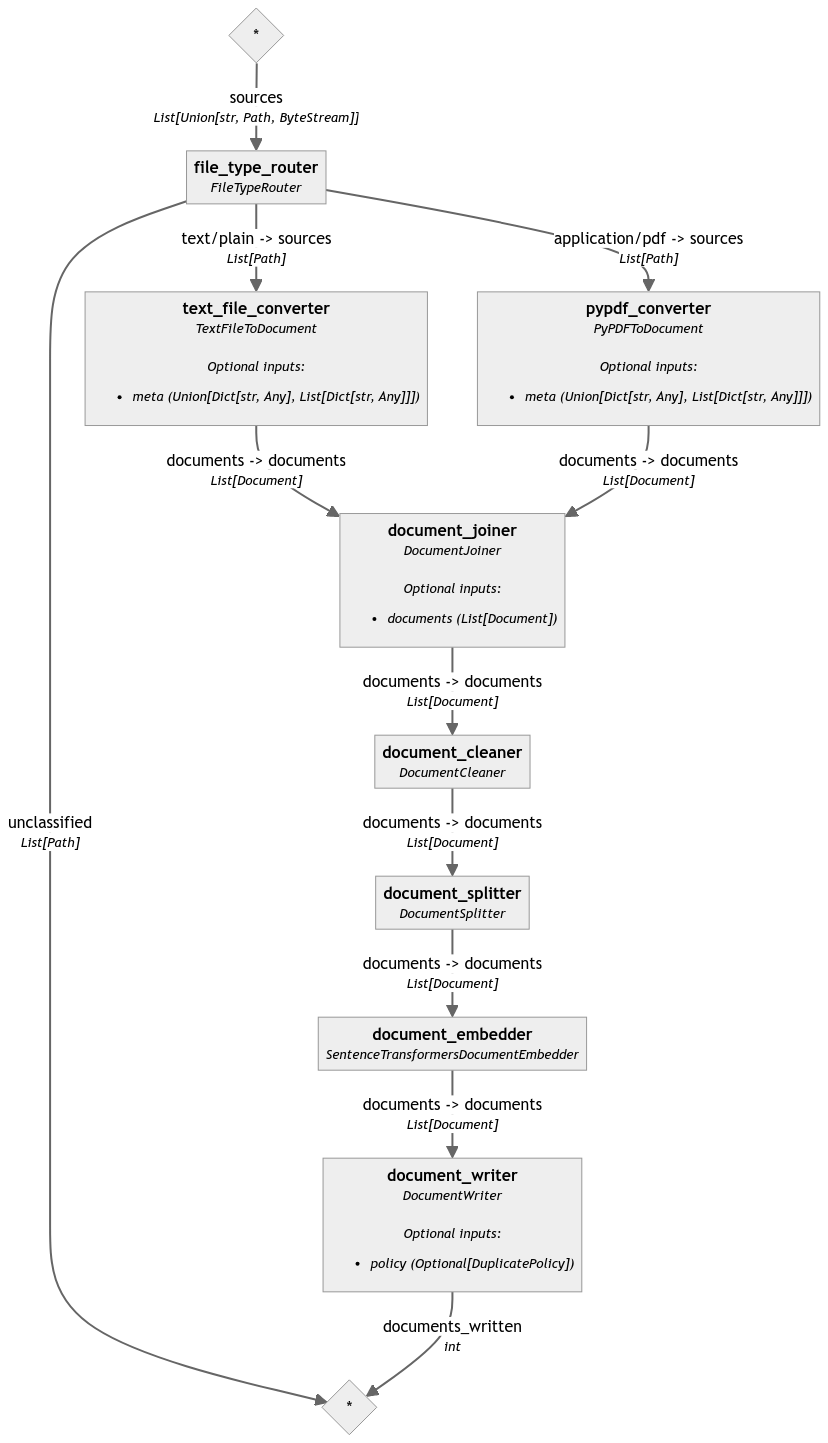

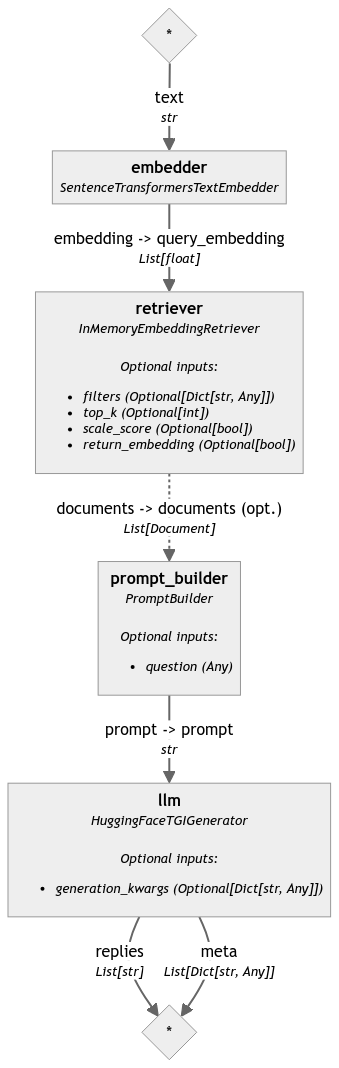

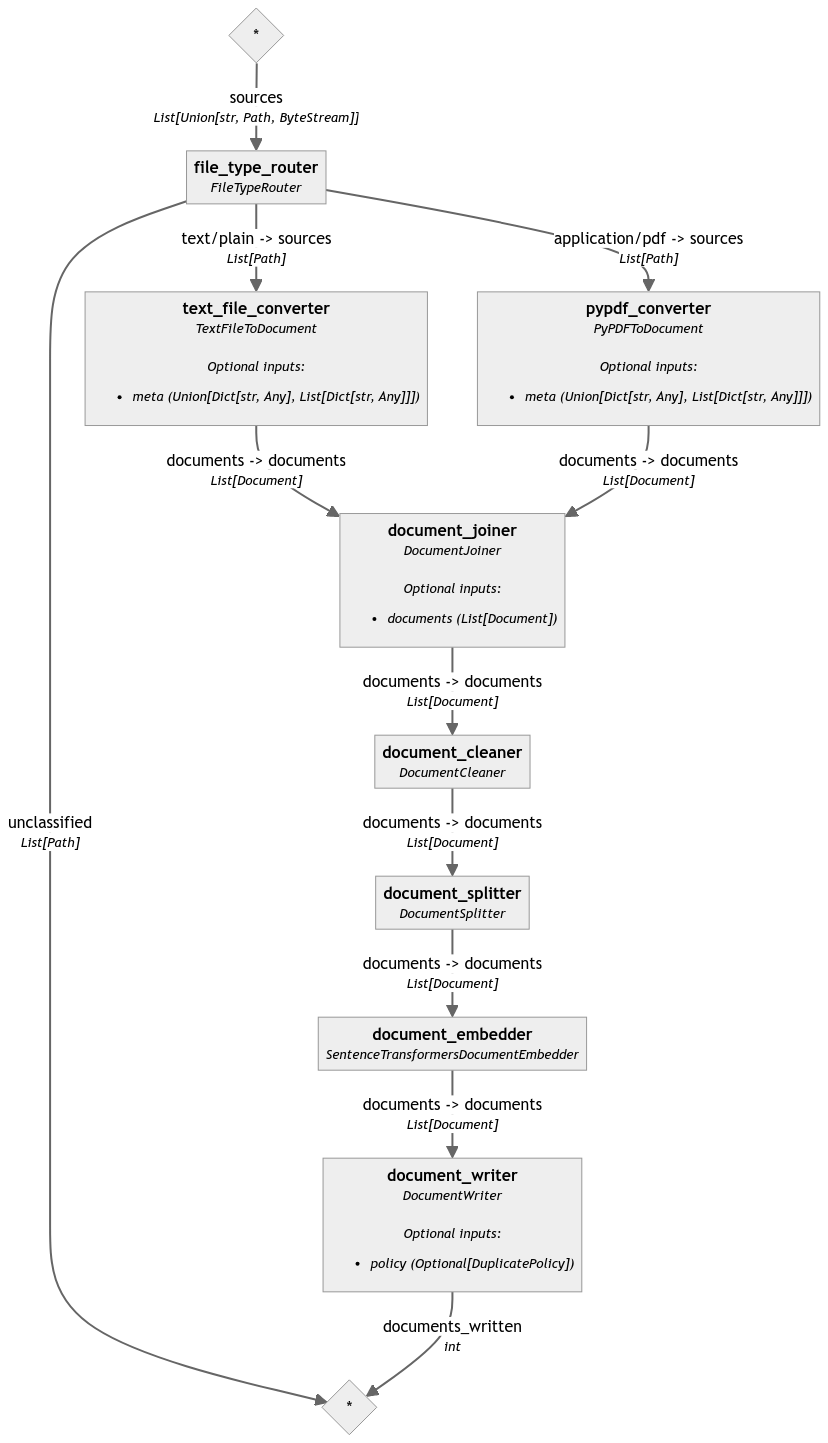

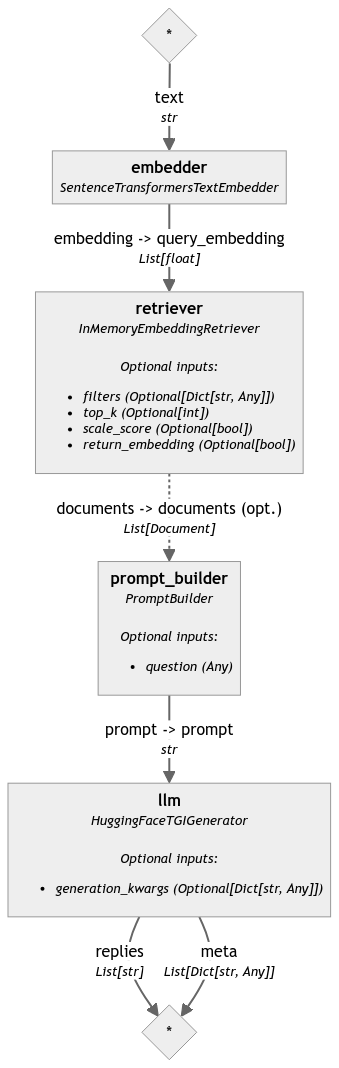

KeyboardInterrupt: 

In [22]:
import os
import glob
import pandas as pd

datasets = sorted(glob.glob(os.path.join(os.getcwd(), 
                                            'data', 
                                            'DRS', 
                                            'dataset', 
                                            'all_drs', 
                                            'dataset_for_-FAR-*.parquet')), 
				key=os.path.getctime, 
				reverse=True)
df_dataset = pd.read_parquet(datasets[0])
df_dataset = df_dataset.reset_index()


for index, row in df_dataset.iterrows():
    if (30<len(row["content"])) and (len(row["content"])<100000):
        # Text file to feed Haystack DocumentStore
        filename = os.path.join(os.getcwd(), 'data', 'DRS', 'dataset', 'all_drs', 'text_files',
                                row["documentGuid"]+'_index='+str(index)+'.txt')
        if not os.path.exists(filename):
            with open(filename, "w") as f:                
                    content_with_meta = "document title: "+row["drs:title"]+"\n\n\n\n"   

                    if str(row["parents_title_list"])!='<NA>':
                        content_with_meta += "document context and subtitles: "+' AND '.join(row["parents_title_list"][2:-2].split(', '))+"\n\n\n\n"            

                    content_with_meta += "content: "+' '.join(row["content"][2:-2].split(', '))
                    f.write(content_with_meta)

In [6]:
import os
import glob
import pandas as pd

# Add metadata
# datasets = sorted(glob.glob(os.path.join(os.getcwd(), 'data', 'DRS', 'dataset', 'all_drs',
#                                          'dataset_for_-FAR-*.parquet')), 
# 				key=os.path.getctime, 
# 				reverse=True)
# df_dataset = pd.read_parquet(datasets[0])

texts = glob.glob(os.path.join(os.getcwd(), 'data', 'DRS', 'dataset', 'all_drs', 'text_files', '*.txt'))#[-10:]

preprocessing_pipeline.run(
    {
        "file_type_router": {
            "sources": texts
        }
    }
)

Batches:   0%|          | 0/11906 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 380962}}

## Pipeline to query documents

In [7]:
import os
from getpass import getpass

with open(os.path.join(os.getcwd(), "hugging_face_token.txt"), "r") as f:
    os.environ["HF_API_TOKEN"] = f.read()

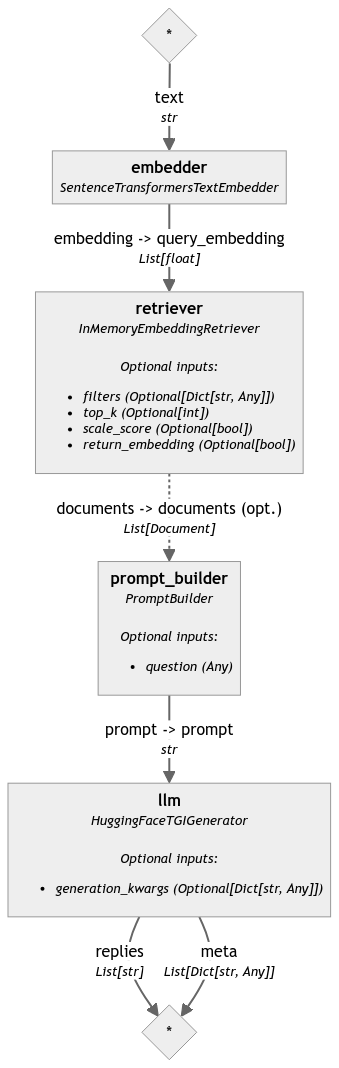

In [8]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceTGIGenerator

template = """
Role: you are an expert in all aspects of operations, engineering, design, maintenance, airworthiness and certification for rotorcraft and airplanes.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
Answer:
"""
pipe = Pipeline()
pipe.add_component("embedder", SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", HuggingFaceTGIGenerator("mistralai/Mistral-7B-Instruct-v0.1"))

pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")

In [19]:
question = (
    "Is it acceptable to install non-required DAL A displays for pilot for situation awareness only in the primary field of view?"
)

# question = (
#     "What is an Acceptable Means of Compliance for a super tiny rechargeable battery?"
# )

response = \
pipe.run(
    {
        "embedder": {"text": question},
        "prompt_builder": {"question": question},
        "llm": {"generation_kwargs": {"max_new_tokens": 600}},
    }
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 No, it is not acceptable to install non-required DAL A displays for pilot for situation awareness only in the primary field of view. The display must be installed such that the pilots have an unobstructed view of the display when seated in their normal position. Additionally, the display must be aligned with and scaled to the external scene and should include the effect of near distance parallax. The display must not cause unacceptable interference with the safe and effective use of aircraft attitudes and wind conditions. A display that provides the pilot monitoring with EFVS sensor imagery is not required for EFVS Approach System operations. However, for EFVS Landing System operations when a minimum flightcrew of more than one pilot is required for the conduct of the operation, the aircraft must be equipped with an operable display that provides the pilot monitoring with EFVS sensor imagery. Any display used to monitor the approach must be located in the cockpit in accordance with 14

In [ ]:
print(response['llm']['replies'][0])

## RAG Pipeline

### Defining a Template Prompt

In [ ]:
from haystack.components.builders import PromptBuilder

template = """
role: you are an expert in all aspects of operations, airworthiness and certification for rotorcraft and airplanes including maintenance and engineering.
task: you provide detailed guidance to an applicant or an operator.
context: rotorcraft and airplanes operations and airworthiness in United States National Airspace. You are using information from the following types of document: Aeronautical Information Publication (AIP), Aeronautical Information Manual (AIM), Advisory Circulars (AC), FAA Orders, FAA Order Handbooks, Federal Aviation Regulations (Title 14 CFR FAR).

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

### Initializing a [Generator](https://docs.haystack.deepset.ai/v2.0/docs/huggingfacelocalgenerator)

In [ ]:
from haystack.components.generators import HuggingFaceLocalGenerator

generator = HuggingFaceLocalGenerator(model_name_or_path="google/flan-t5-xl",
                                      task="text2text-generation",
                                      generation_kwargs={
                                        "max_new_tokens": 100,
                                        "temperature": 0.9,
                                        })
generator.warm_up()

### Building the Pipeline

In [1]:
from haystack.pipeline import Pipeline

basic_rag_pipeline = Pipeline()
# Add components to your pipeline
basic_rag_pipeline.add_component("retriever", retriever)
basic_rag_pipeline.add_component("prompt_builder", prompt_builder)
basic_rag_pipeline.add_component("llm", generator)

# Now, connect the components to each other
basic_rag_pipeline.connect("retriever", "prompt_builder.documents")
basic_rag_pipeline.connect("prompt_builder", "llm")

/home/victor/anaconda3/envs/drs_50_Haystack_RAG/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: cannot import name 'send_event' from 'haystack.telemetry' (/home/victor/anaconda3/envs/drs_50_Haystack_RAG/lib/python3.10/site-packages/haystack/telemetry/__init__.py)

### Asking a Question

In [ ]:
# question = "What is an Acceptable Means of Compliance for a super tiny rechargeable battery?"
# question = "What is an Acceptable Means of Compliance for a super tiny rechargeable battery?"


response = basic_rag_pipeline.run({"retriever": {"query": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])